Include global stopping strategy: 
https://ax.dev/tutorials/gss.html

Also note warnings:

- FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))

- FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object. args["df"] = pd.read_json(args["df"]["value"], dtype=False)

- The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.



### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ax
# import botorch
# import gpytorch

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

### Training Data and Parameters

In [2]:
unique_parameters = ["tungstate_concentration", "current_density", "deposition_time", "pH"] 
# temperature avoided, kept constant at 25 C

# EXAMPLE, here use actual data
X_train = np.array([[0.05, 10, 500, 5],
               [0.05, 50, 300, 6],
               [0.1, 10, 300, 7],
               [0.1, 10, 600, 8],
               
               [0.1, 50, 600, 7.5],
               [0.1, 100, 600, 10],
               [0.1, 50, 400, 6.5],
               [0.1, 30, 600, 8.5],
               [0.15, 10, 600, 9.5],
               [0.15, 50, 300, 9.5],
               
               # NEW OPTIMIZATION DATA    
               ])

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=unique_parameters)
X_train

,tungstate_concentration,current_density,deposition_time,pH
0,0.05,10.0,500.0,5.0
1,0.05,50.0,300.0,6.0
2,0.10,10.0,300.0,7.0
3,0.10,10.0,600.0,8.0
4,0.10,50.0,600.0,7.5
5,0.10,100.0,600.0,10.0
6,0.10,50.0,400.0,6.5
7,0.10,30.0,600.0,8.5
8,0.15,10.0,600.0,9.5
9,0.15,50.0,300.0,9.5


In [3]:
# Number of data points
n_train = X_train.shape[0]

unique_objectives = ["overpotential", "overpotential_slope"]

# EXAMPLE, here use actual observations
y_train = np.array([[-358,0.00015], 
                    [-319,0.000066], 
                    [-377,0.0001], 
                    [-319,-0.000518],
                    [-286,0.00008], 
                    [-312,0.000029], 
                    [-309,-0.000057], 
                    [-290,0.001656],
                    [-329,0.000131], 
                    [-305,-0.000064],

                    # NEW OPTIMIZATION DATA                    
                    ])

# Convert to dataframe
y_train = pd.DataFrame(y_train, columns=unique_objectives)
y_train

,overpotential,overpotential_slope
0,-358.0,0.000150
1,-319.0,0.000066
2,-377.0,0.000100
3,-319.0,-0.000518
4,-286.0,0.000080
5,-312.0,0.000029
6,-309.0,-0.000057
7,-290.0,0.001656
8,-329.0,0.000131
9,-305.0,-0.000064


In [4]:
parameters=[
        {
            "name": "tungstate_concentration",
            "type": "range",
            "bounds": [0.05, 0.2],
        },
        {
            "name": "current_density",
            "type": "range",
            "bounds": [5, 125],
        },
        {
            "name": "deposition_time",
            "type": "range",
            "bounds": [60, 600],
        },
        {
            "name": "pH",
            "type": "range",
            "bounds": [5, 10],
        }
        ]

### Generation Strategy

In [5]:
# Specify a custom generation strategy - Skips the pseudo-random initial suggested points 
gs = GenerationStrategy(
    steps=[
        # Quasi-random Sobol sequence along with my initial data
        # GenerationStep(
            # model=Models.SOBOL, 
            # num_trials=5,  # How many trials to produce during generation step
            # min_trials_observed=3,  # How many trials to be completed before next model
            # max_parallelism=5  # Max parallelism for this step
        # ),
        ################
        # Skips SOBOL sampling step (which is the default first step) and uses the initial data provided
        # Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model = Models.MOO,
            # Uses qNEHVI by default, use instead of GPEI (for single) and PAREGO (for multi but worse than qNEHVI)
            # Not passing any information about the observation noise; so the model is inferring a Gaussian noise level on the observations - SingleTaskGP
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3  # BATCH/Parallelism limit for this step, often lower than for Sobol
                    )
            ]
)

### Setup the experiment

In [6]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="NiW",
    parameters=parameters,
    objectives={
        "overpotential": ObjectiveProperties(minimize=False, threshold = -350), # How ambitious + what is max (min) allowable value?
        "overpotential_slope": ObjectiveProperties(minimize=False, threshold = -0.001) # Not clear, looking for >=0 if possible
    },
    overwrite_existing_experiment=False, # I am saving my data anyway, but just to make sure
    is_test = False, # Set this to False when running a REAL experiment
    choose_generation_strategy_kwargs = {"max_parallelism_override": 3} # Parallel/Batch evaluation, max batch size = 3
)

[INFO 02-04 14:41:20] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-04 14:41:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter tungstate_concentration. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-04 14:41:20] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter current_density. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-04 14:41:20] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter deposition_time. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

### Input training data (run this only the FIRST time)

Doing this manually while also specifying parameter data types, instead of the simply structure in the tutorial, to avoid odd errors (e.g. initial data is one type, while in the dataframe it is another + need to use iloc function to iterate through dataframe).

In [7]:
# Initialize trial index
trial_index = 0

# Attach the training data
for i in range(n_train):
    trial_parameters = {
        param: int(value) if param in ["current_density", "deposition_time", "pH"] else float(value)
        for param, value in X_train.iloc[i, :].items()
    }
    
    # Create a dictionary with the raw data for each objective
    trial_raw_data = {obj: float(value) for obj, value in zip(unique_objectives, y_train.iloc[i])}
    
    # Attach trial and complete it
    ax_client.attach_trial(trial_parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=trial_raw_data)
    
    # Increment trial index
    trial_index += 1

[INFO 02-04 14:41:22] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 10, 'deposition_time': 500, 'pH': 5}] as trial 0.
[INFO 02-04 14:41:22] ax.service.ax_client: Completed trial 0 with data: {'overpotential': (-358.0, None), 'overpotential_slope': (0.00015, None)}.
[INFO 02-04 14:41:22] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 300, 'pH': 6}] as trial 1.
[INFO 02-04 14:41:22] ax.service.ax_client: Completed trial 1 with data: {'overpotential': (-319.0, None), 'overpotential_slope': (6.6e-05, None)}.
[INFO 02-04 14:41:22] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.1, 'current_density': 10, 'deposition_time': 300, 'pH': 7}] as trial 2.
[INFO 02-04 14:41:22] ax.service.ax_client: Completed trial 2 with data: {'overpotential': (-377.0, None), 'overpotential_slope': (0.0001, None)}.
[INFO 02-04 14:41:

### Run optimization and get next suggestions (repeat cell as needed)

In [8]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 02-04 14:41:28] ax.service.ax_client: Generated new trial 10 with parameters {'tungstate_concentration': 0.09584, 'current_density': 49, 'deposition_time': 600, 'pH': 9}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-04 14:41:28] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.09583970693987534, 'current_density': 49, 'deposition_time': 600, 'pH': 9}


[INFO 02-04 14:41:31] ax.service.ax_client: Generated new trial 11 with parameters {'tungstate_concentration': 0.132893, 'current_density': 50, 'deposition_time': 600, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-04 14:41:31] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.13289313283346882, 'current_density': 50, 'deposition_time': 600, 'pH': 8}


[INFO 02-04 14:41:35] ax.service.ax_client: Generated new trial 12 with parameters {'tungstate_concentration': 0.055994, 'current_density': 46, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.0559944442894985, 'current_density': 46, 'deposition_time': 600, 'pH': 8}


In [9]:
# Confirm runnign trials
ax_client.generation_strategy.trials_as_df

[INFO 02-04 14:41:37] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,MOO,10,RUNNING,"{'10_0': {'tungstate_concentration': 0.1, 'cur..."
1,GenerationStep_0,MOO,11,RUNNING,"{'11_0': {'tungstate_concentration': 0.13, 'cu..."
2,GenerationStep_0,MOO,12,RUNNING,"{'12_0': {'tungstate_concentration': 0.06, 'cu..."


### Perform lab experiments and get new objectives

In [10]:
# Complete pendings trials
# We manually set SEM = None to indicate that we know the function to be noisy, but would like Ax to estimate the noise for us.
ax_client.complete_trial(trial_index=10, raw_data={'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=11, raw_data={'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)})
ax_client.complete_trial(trial_index=12, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)})

[INFO 02-04 14:41:39] ax.service.ax_client: Completed trial 10 with data: {'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 02-04 14:41:39] ax.service.ax_client: Completed trial 11 with data: {'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)}.
[INFO 02-04 14:41:39] ax.service.ax_client: Completed trial 12 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)}.


In [11]:
# Confirm completed trials
ax_client.generation_strategy.trials_as_df

[INFO 02-04 14:41:41] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,MOO,10,COMPLETED,"{'10_0': {'tungstate_concentration': 0.1, 'cur..."
1,GenerationStep_0,MOO,11,COMPLETED,"{'11_0': {'tungstate_concentration': 0.13, 'cu..."
2,GenerationStep_0,MOO,12,COMPLETED,"{'12_0': {'tungstate_concentration': 0.06, 'cu..."


#### Repeat etc.

In [12]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 02-04 14:41:48] ax.service.ax_client: Generated new trial 13 with parameters {'tungstate_concentration': 0.104944, 'current_density': 52, 'deposition_time': 575, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-04 14:41:48] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.10494403518861209, 'current_density': 52, 'deposition_time': 575, 'pH': 8}


[INFO 02-04 14:41:53] ax.service.ax_client: Generated new trial 14 with parameters {'tungstate_concentration': 0.158626, 'current_density': 54, 'deposition_time': 585, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-04 14:41:53] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.15862630288242435, 'current_density': 54, 'deposition_time': 585, 'pH': 8}


[INFO 02-04 14:41:57] ax.service.ax_client: Generated new trial 15 with parameters {'tungstate_concentration': 0.069787, 'current_density': 52, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.06978719511751183, 'current_density': 52, 'deposition_time': 600, 'pH': 8}


In [13]:
ax_client.complete_trial(trial_index=13, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=14, raw_data={'overpotential': (-259.0, None), 'overpotential_slope': (+0.00004, None)})
ax_client.complete_trial(trial_index=15, raw_data={'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)})

[INFO 02-04 14:42:00] ax.service.ax_client: Completed trial 13 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 02-04 14:42:00] ax.service.ax_client: Completed trial 14 with data: {'overpotential': (-259.0, None), 'overpotential_slope': (4e-05, None)}.
[INFO 02-04 14:42:00] ax.service.ax_client: Completed trial 15 with data: {'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)}.


In [14]:
ax_client.generation_strategy.trials_as_df

[INFO 02-04 14:42:01] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,MOO,10,COMPLETED,"{'10_0': {'tungstate_concentration': 0.1, 'cur..."
1,GenerationStep_0,MOO,11,COMPLETED,"{'11_0': {'tungstate_concentration': 0.13, 'cu..."
2,GenerationStep_0,MOO,12,COMPLETED,"{'12_0': {'tungstate_concentration': 0.06, 'cu..."
3,GenerationStep_0,MOO,13,COMPLETED,"{'13_0': {'tungstate_concentration': 0.1, 'cur..."
4,GenerationStep_0,MOO,14,COMPLETED,"{'14_0': {'tungstate_concentration': 0.16, 'cu..."
5,GenerationStep_0,MOO,15,COMPLETED,"{'15_0': {'tungstate_concentration': 0.07, 'cu..."


### Save/Load the experiment

In [15]:
# Save the experiment state to disk.
ax_client.save_to_json_file("ax_client_snapshot.json")  

[INFO 02-04 14:42:02] ax.service.ax_client: Saved JSON-serialized state of optimization to `ax_client_snapshot.json`.


In [16]:
# Restore the experiment state from disk.  
ax_client = AxClient.load_from_json_file("ax_client_snapshot.json") 
# For custom filepath, pass `filepath` argument.
# For any loading issues: https://github.com/facebook/Ax/issues/1565

c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:203: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  args["df"] = pd.read_json(args["df"]["value"], dtype=False)
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:203: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  args["df"] = pd.read_json(args["df"]["value"], dtype=False)
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:203: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  args["df"] = pd.read_json(args["df"]["value"], dtype=False)
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\li

### Confirm model instantiation and data so far

In [17]:
print('model:', ax_client.generation_strategy.model)
ax_client.fit_model()

[INFO 02-04 14:42:06] ax.service.ax_client: get_model_predictions() has been called when no model is instantiated. Attempting to instantiate the model for the first time.


model: None


[INFO 02-04 14:42:07] ax.service.ax_client: Successfully instantiated a model for the first time.
[INFO 02-04 14:42:07] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


In [18]:
ax_client.experiment.fetch_data().df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,overpotential,-358.000000,NaN,0
1,0_0,overpotential_slope,0.000150,NaN,0
2,1_0,overpotential,-319.000000,NaN,1
3,1_0,overpotential_slope,0.000066,NaN,1
4,2_0,overpotential,-377.000000,NaN,2
5,2_0,overpotential_slope,0.000100,NaN,2
6,3_0,overpotential,-319.000000,NaN,3
7,3_0,overpotential_slope,-0.000518,NaN,3
8,4_0,overpotential,-286.000000,NaN,4
9,4_0,overpotential_slope,0.000080,NaN,4


### Get Pareto optimal parameters

In [ ]:
pareto_optimal_params = ax_client.get_pareto_optimal_parameters(use_model_predictions=True) 
# use_model_predictions=True by default, also try False?
print("Pareto optimal parameters:", pareto_optimal_params)

### Plot (Posterior) Pareto front 

In [ ]:
# Plotting imports and initialization
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier

In [ ]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["overpotential", "overpotential_slope"],
    num_points=16
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

## Hypervolume: Evaluating the Quality of a Pareto Front

#### Hypervolume for specific trial

In [ ]:
# Do this for every trial - by default calculates hypervolume UP TO and INCLUDING the current trial
# Observe difference betweeen use_model_predictions=True/False

trial_indices = [15]
model_true = ax_client.get_hypervolume(trial_indices = trial_indices, use_model_predictions=True)
model_false = ax_client.get_hypervolume(trial_indices = trial_indices, use_model_predictions=False)

print(f'Hypervolume With Model Predictions: {model_true}, Without: {model_false}, For trial: {trial_indices}')

In [ ]:
# OR use this to get the optimization trace of the ENTIRE experiment i.e. all trials:
# Equivalent to calling _get_hypervolume repeatedly, with an increasing sequence of trial_indices 
# and with use_model_predictions = FALSE, though this does it more efficiently.
hypervolume_trace = ax_client.get_trace()
print(hypervolume_trace)

#### Hypervolume over iterations = Optimization trace for multi-objective 

In [ ]:
# Plot the hypervolume trace
plt.plot(range(1, len(hypervolume_trace) + 1), hypervolume_trace, label='Hypervolume', marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Hypervolume')
plt.title('Hypervolume over Iterations')
plt.grid(True)
plt.legend()
plt.show()

## Visualizations

In [ ]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.contour import interact_contour
from ax.plot.scatter import (
    interact_fitted,
    plot_objective_vs_constraints,
    tile_fitted,
)
from ax.plot.slice import plot_slice

### Cross validation

In [ ]:
model = ax_client.generation_strategy.model
cv_results = cross_validate(model, folds= -1) # default folds
render(interact_cross_validation(cv_results))

#### Contour plot

In [ ]:
# Interactive contour plots, able to switch between different parameter-objective combinations.
render(interact_contour(model, metric_name="overpotential"))

#### Tradeoff plot 

In [ ]:
render(plot_objective_vs_constraints(model, "overpotential", rel=False)) # rel = False

#### Slice plot

In [ ]:
# Slice plot, can be done for all different parameter-objective combinations.
render(plot_slice(model, "pH", "overpotential"))

## More visualizations

Data conversion from the Ax dataframe to a list, for visualization purposes.

In [40]:
# Get dataframe and drop the 'sem' column
data_df = ax_client.experiment.fetch_data().df
data_df = data_df.drop(columns=['sem'])

# Convert the DataFrame to a list of lists
data_list = []

for trial in data_df['trial_index'].unique():
    trial_data = data_df[data_df['trial_index'] == trial]
    
    # Extract data for 'overpotential' and 'overpotential_slope'
    overpotential_data = trial_data.loc[trial_data['metric_name'] == 'overpotential', 'mean'].tolist()[0]
    slope_data = trial_data.loc[trial_data['metric_name'] == 'overpotential_slope', 'mean'].tolist()[0]
    
    # Combine the data into a list of tuples
    trial_data_list = [overpotential_data, slope_data]
    
    # Extend the main list
    data_list.append(trial_data_list)

# Now data_list has the format you want
print(data_list)

[[-358.0, 0.00015000000000000001], [-319.0, 6.599999999999999e-05], [-377.0, 0.0001], [-319.0, -0.000518], [-286.0, 8e-05], [-312.0, 2.9e-05], [-309.0, -5.6999999999999996e-05], [-290.0, 0.001656], [-329.0, 0.00013099999999999999], [-305.0, -6.4e-05], [-260.0, -0.002], [-255.0, -0.02], [-245.0, -0.0004], [-245.0, -0.002], [-259.0, 4e-05], [-269.0, -0.0034000000000000002]]


### Plot by batch or by trial

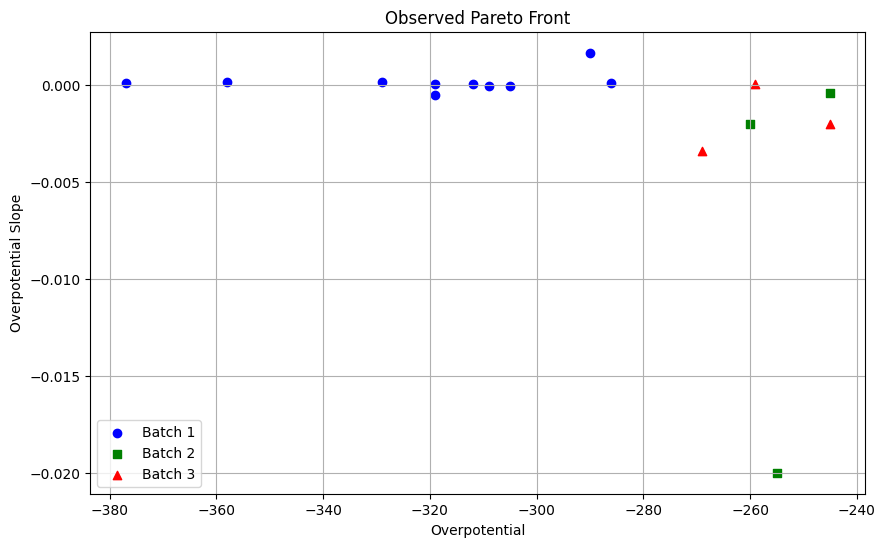

In [42]:
from src.ax_code.visualizations import plot_pareto

# Need to be manually organized by batch, see visualizations.py 
# (needed for the 'by batch' plot, doesn't matter for the rest)

# Choose the visualization type ('batch' or 'trial')
visualization_type = 'batch' 

# Call the function to plot the Pareto front
plot_pareto(data_list, visualization_type)

### Plot by tracking one of the two objectives over the trials

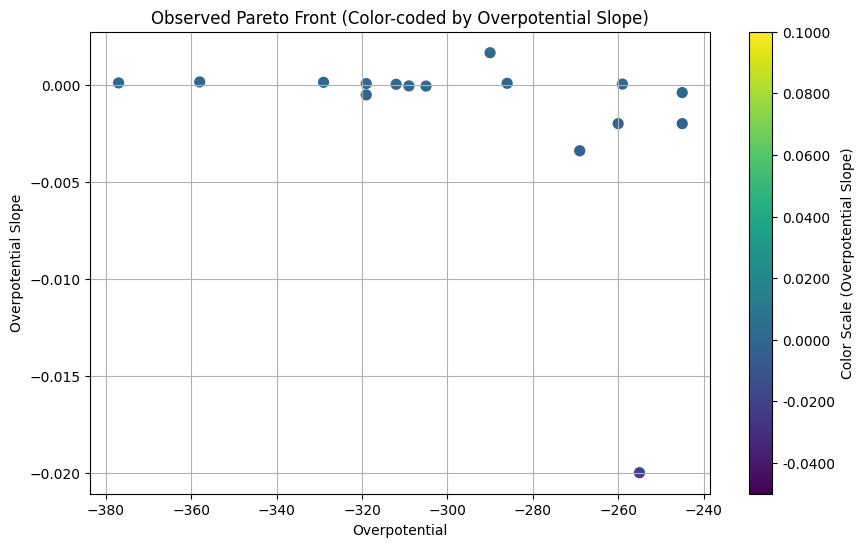

In [43]:
from src.ax_code.visualizations import plot_pareto_objective

# Choose the visualization type ('value' or 'slope')
visualization_type = 'slope' 

# Call the function to plot the Pareto front based on tracking the chosen objective
plot_pareto_objective(data_list, visualization_type)